# Decision Tree Discussion Post

## Data Prep 

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import tree
import matplotlib.pyplot as plt

### Creating Data

In [4]:
np.random.seed(33)

n = 4000

# using GPA and parental income as predictors
data = pd.DataFrame({
    "GPA": np.random.uniform(1.0, 4.0, n),                
    "Parental_Income": np.random.uniform(30_000, 140_000, n)
})

data.head()

,GPA,Parental_Income
0,1.745530,63450.062596
1,2.349926,110811.736844
2,2.232822,52790.794581
3,1.780899,49306.080738
4,3.611187,64317.870611


### Creating the decision thresholds

In [5]:
outcomes = []
for i in range(n):
    gpa = data.loc[i, 'GPA']
    income = data.loc[i, 'Parental_Income']

    if gpa > 3.5 and income > 83730:
        outcomes.append(1)
    else:
        outcomes.append(0)

data['Above_median'] = outcomes
print("Original distribution:")
print(data['Above_median'].value_counts())

Original distribution:
Above_median
0    3624
1     376
Name: count, dtype: int64


## Part 1: Minimal Noise (Depth=3)

In [6]:
np.random.seed(33)           
flip_rate = 0.10
mask = np.random.rand(n) < flip_rate
data['noisy_labels'] = np.where(mask, 1 - data['Above_median'], data['Above_median'])
print(f"\nFlipped {mask.sum()} labels ({mask.mean():.1%})")


Flipped 417 labels (10.4%)


In [7]:
feature_cols = ['GPA', 'Parental_Income']
X = data[feature_cols]
y = data['noisy_labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=39, stratify=y
)

In [8]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

y_train_pred = dtree.predict(X_train)
y_test_pred  = dtree.predict(X_test)
print("Accuracy (train):", accuracy_score(y_train, y_train_pred))
print("Accuracy (test): ", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, target_names=["Below","Above"]))


Accuracy (train): 1.0
Accuracy (test):  1.0

Confusion Matrix:
 [[962   0]
 [  0 238]]

Classification Report:
               precision    recall  f1-score   support

       Below       1.00      1.00      1.00       962
       Above       1.00      1.00      1.00       238

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



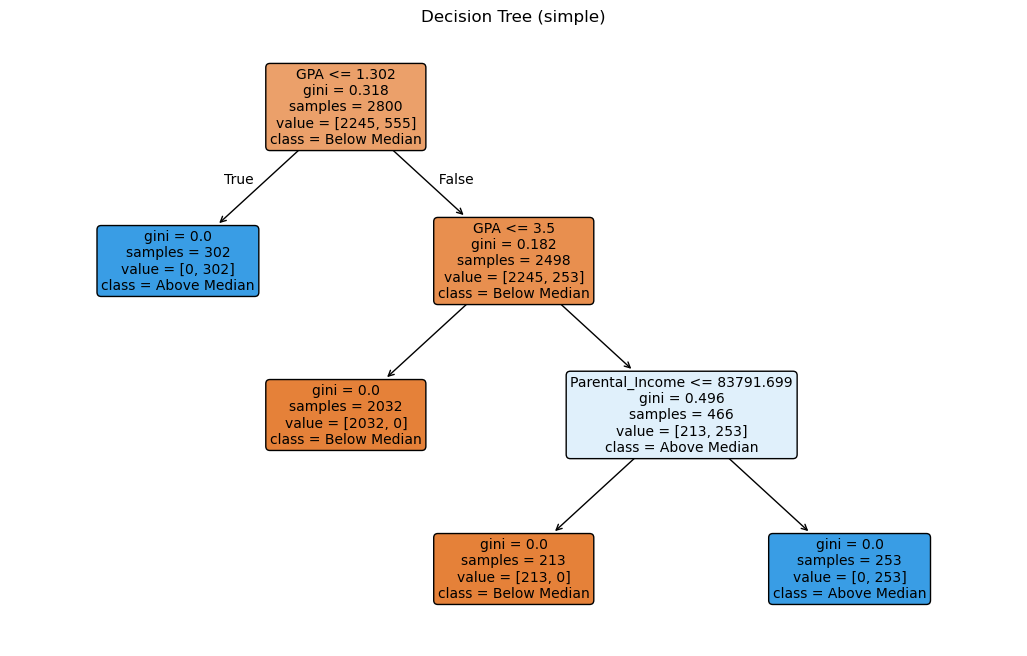

3

In [9]:
plt.figure(figsize=(13, 8))
plot_tree(
    dtree,
    feature_names=feature_cols,
    class_names=["Below Median", "Above Median"],
    filled=True, rounded=True, fontsize=10
)
plt.title("Decision Tree (simple)")
plt.show()
dtree.get_depth()

## Part 2: Feature Noise Added (Depth=15)

In [10]:
data['GPA'] = np.clip(data['GPA'] + np.random.normal(0, 0.1, n), 1.0, 4.0)
data['Parental_Income'] = np.maximum(data['Parental_Income'] + np.random.normal(0, 8000, n), 0)

In [11]:
feature_cols = ['GPA', 'Parental_Income']
X = data[feature_cols]
y = data['noisy_labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=39, stratify=y
)

data.to_csv('DecisionTree_ComplexData.csv', index=False)

In [12]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

y_train_pred = dtree.predict(X_train)
y_test_pred  = dtree.predict(X_test)
print("Accuracy (train):", accuracy_score(y_train, y_train_pred))
print("Accuracy (test): ", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, target_names=["Below","Above"]))


Accuracy (train): 1.0
Accuracy (test):  0.9366666666666666

Confusion Matrix:
 [[934  28]
 [ 48 190]]

Classification Report:
               precision    recall  f1-score   support

       Below       0.95      0.97      0.96       962
       Above       0.87      0.80      0.83       238

    accuracy                           0.94      1200
   macro avg       0.91      0.88      0.90      1200
weighted avg       0.94      0.94      0.94      1200



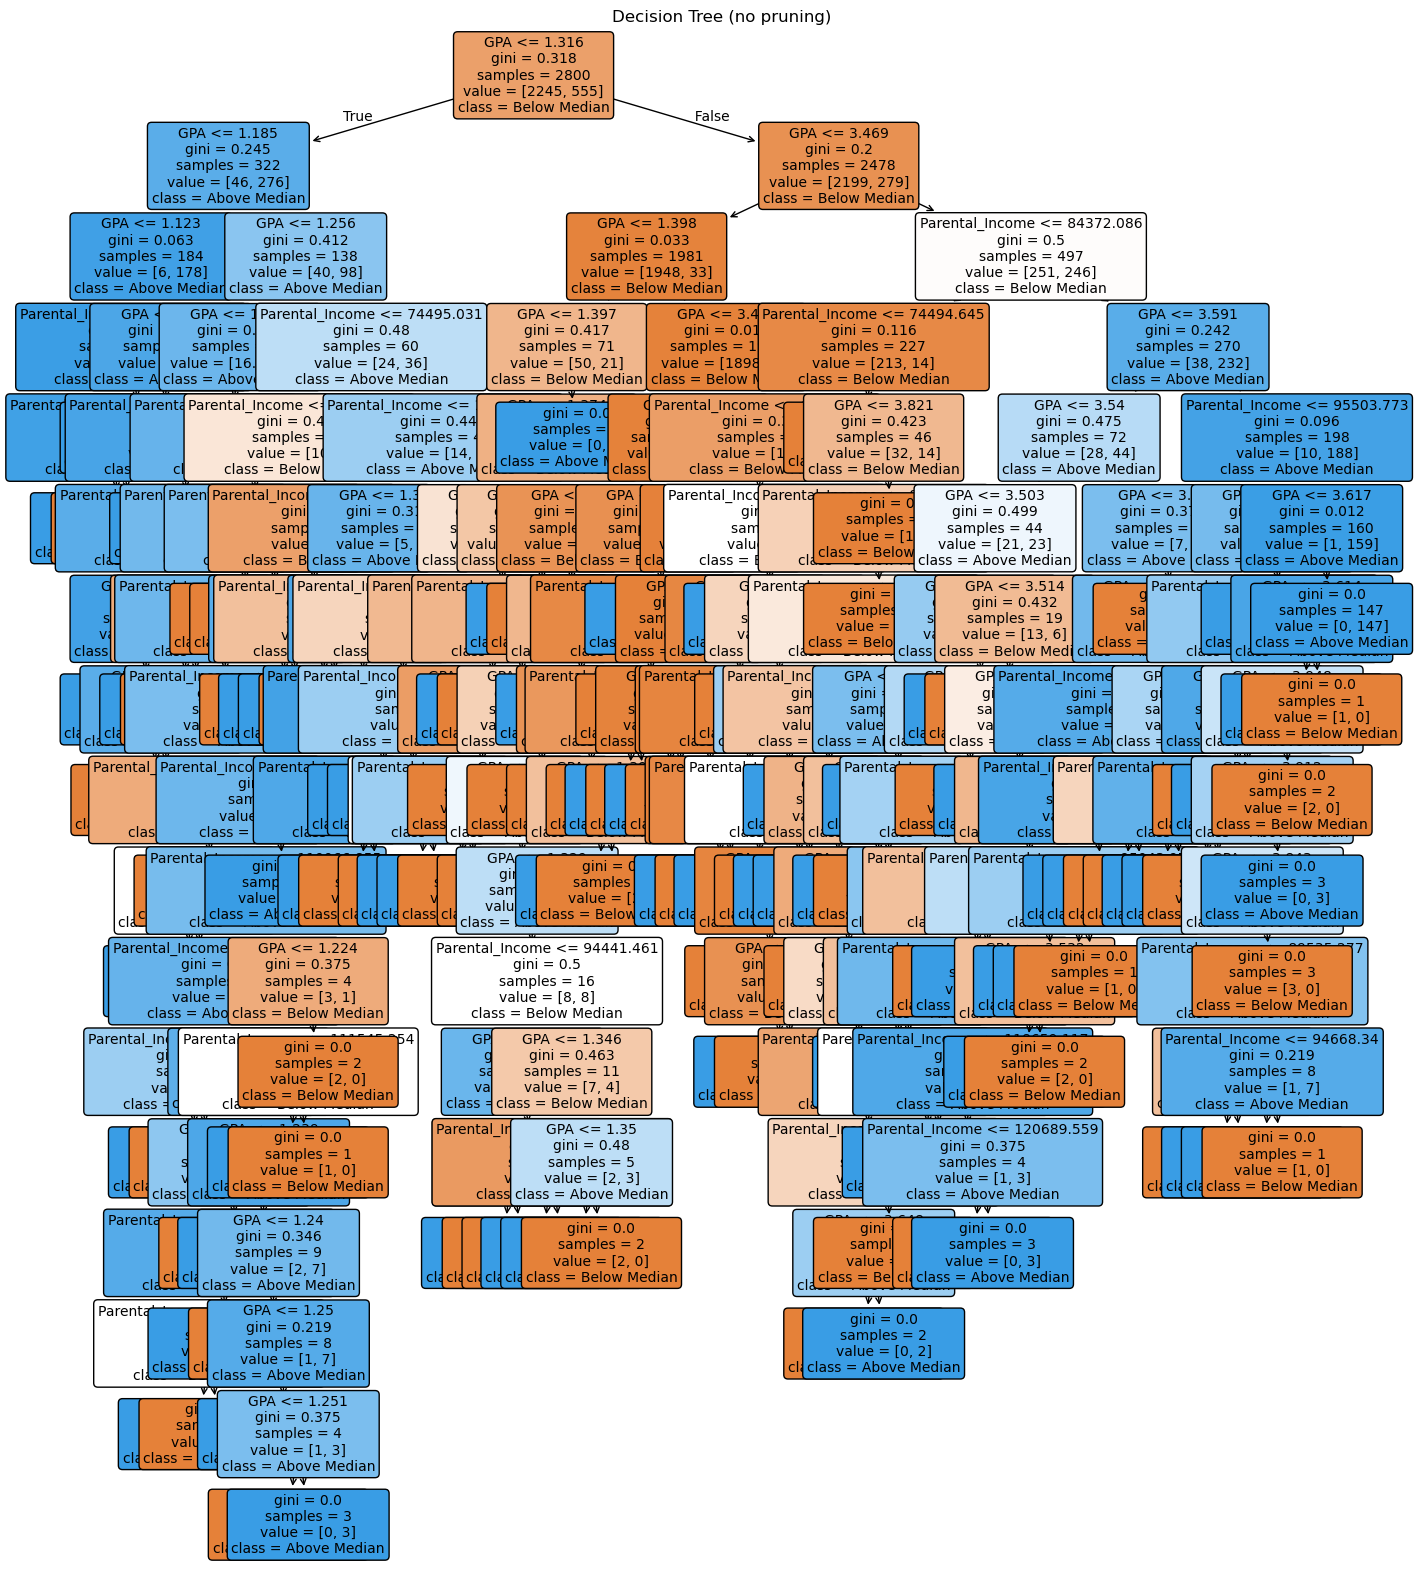

16

In [13]:
plt.figure(figsize=(16, 20))
plot_tree(
    dtree,
    feature_names=feature_cols,
    class_names=["Below Median", "Above Median"],
    filled=True, rounded=True, fontsize=10
)
plt.title("Decision Tree (no pruning)")
plt.show()
dtree.get_depth()

## Part 3: Pruned Model (Depth=8)

In [14]:
path = DecisionTreeClassifier(random_state=33).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

scores = []
for alpha in ccp_alphas:
    model = DecisionTreeClassifier(random_state=33, ccp_alpha=alpha)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))

best_alpha = ccp_alphas[np.argmax(scores)]
dtree = DecisionTreeClassifier(random_state=33, ccp_alpha=best_alpha)
dtree.fit(X_train, y_train)

y_train_pred = dtree.predict(X_train)
y_test_pred  = dtree.predict(X_test)
print("Accuracy (train):", accuracy_score(y_train, y_train_pred))
print("Accuracy (test): ", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, target_names=["Below","Above"]))

Accuracy (train): 0.9764285714285714
Accuracy (test):  0.9541666666666667

Confusion Matrix:
 [[935  27]
 [ 28 210]]

Classification Report:
               precision    recall  f1-score   support

       Below       0.97      0.97      0.97       962
       Above       0.89      0.88      0.88       238

    accuracy                           0.95      1200
   macro avg       0.93      0.93      0.93      1200
weighted avg       0.95      0.95      0.95      1200



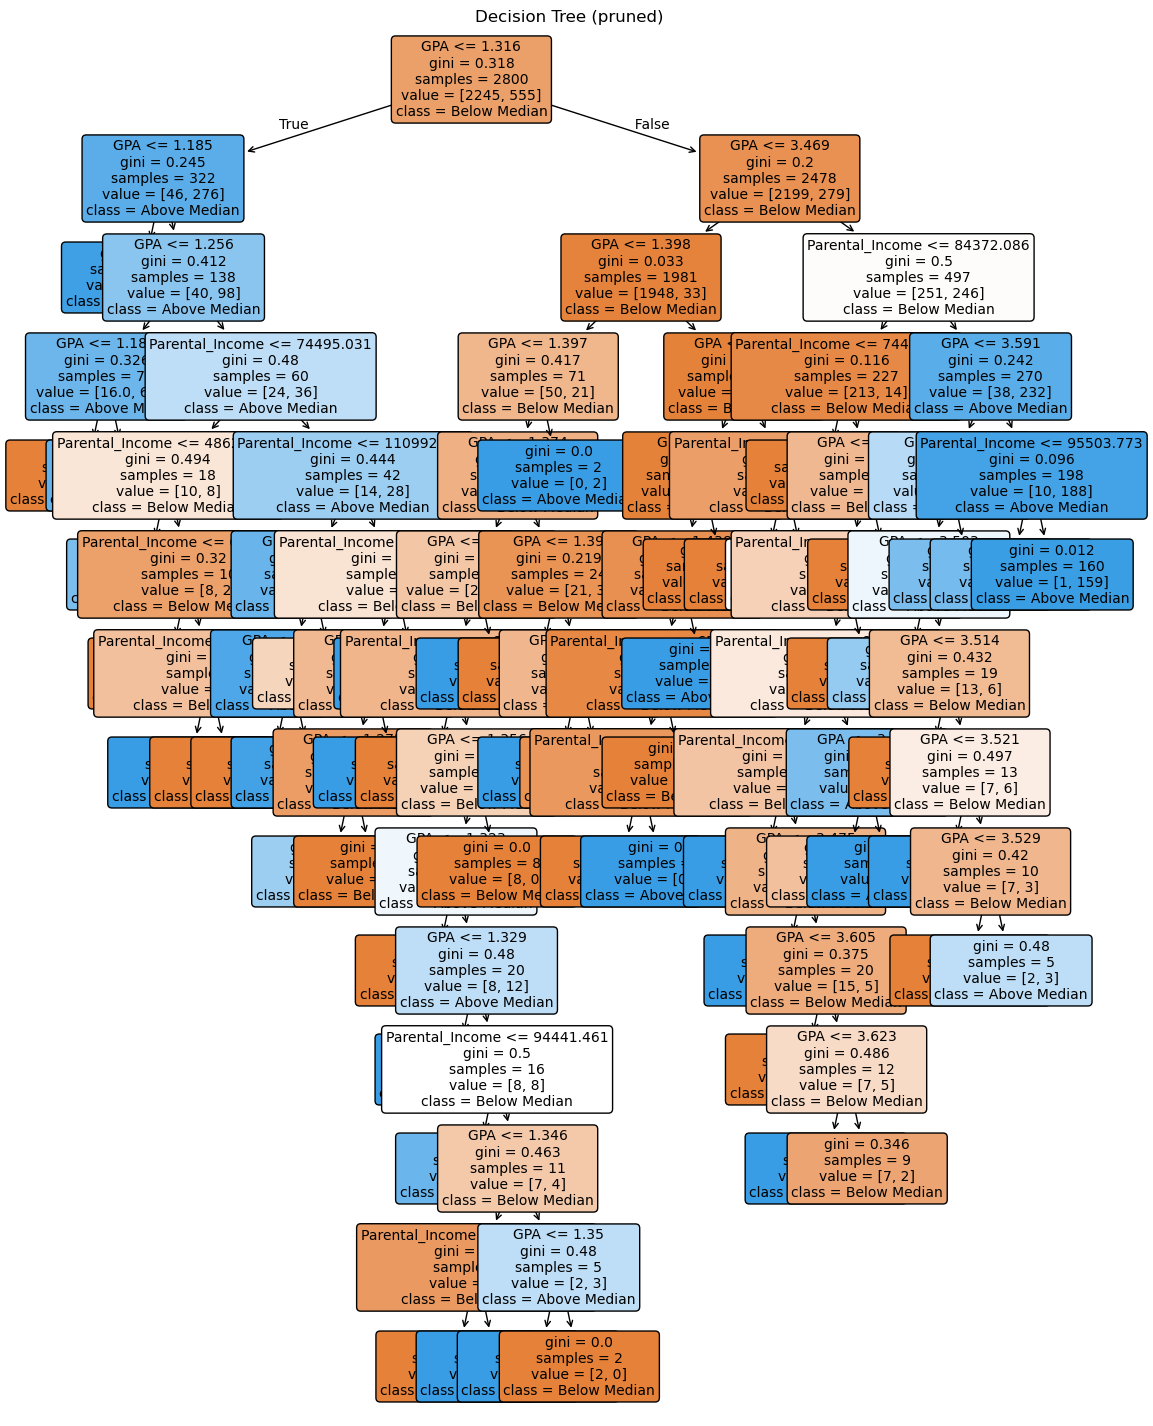

13

In [15]:
plt.figure(figsize=(13, 18))
plot_tree(
    dtree,
    feature_names=feature_cols,
    class_names=["Below Median", "Above Median"],
    filled=True, rounded=True, fontsize=10
)
plt.title("Decision Tree (pruned)")
plt.show()
dtree.get_depth()